In [1]:
#importações
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Carrega dados e metadados(cats_vs_dogs do TensorFlow)
splits = ["train[:80%]", "train[80%:90%]", "train[90%:100%]"] #define divisao dos dados para treinamento, teste e validação
train_ds, val_ds, test_ds = tfds.load("cats_vs_dogs",
                                       split=splits,
                                       as_supervised=True, #imagem, rótulo
                                       with_info=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.UJAIW3_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
IMG_SIZE = (160, 160) #definição da dimensao da imagem
BATCH_SIZE = 32 #definição de lotes de imagens

#pré-processamento da imagem
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

#faz ajustes aleatórios nas imagens pro modelo "aprender" com mais eficiência
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

# preparação do conjunto de treino
train_ds = (train_ds.map(preprocess)
                    .map(augment)
                    .shuffle(1000)
                    .batch(BATCH_SIZE)
                    .prefetch(tf.data.AUTOTUNE))

# preparação do conjunto de validação(augment nao foi utilizada augmentação, para focar na avaliação de imagens reais, sem distorções)
val_ds = (val_ds.map(preprocess)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE))


In [4]:
#definição do modelo base com MobileNetV2(transfer learning)
base_model = tf.keras.applications.MobileNetV2(input_shape=(*IMG_SIZE, 3), #define o tamanho de entrada da imagem e canais de cor(3 ou RGB)
                                               include_top=False, # remove a parte final do modelo original, que fazia classificação de 1000 classes do ImageNet.
                                               weights="imagenet")

base_model.trainable = False #congela modelo base

#definição do modelo final(sequencial)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), #Reduz as saídas do base_model para um vetor pequeno.
    layers.Dense(1, activation="sigmoid") #definição da última camada com apenas 1 neurônio, para fazer a classificação binária
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
#compilação e treinamento do modelo

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 291s 488ms/step - accuracy: 0.9386 - loss: 0.1530 - val_accuracy: 0.9751 - val_loss: 0.0652
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 272s 466ms/step - accuracy: 0.9780 - loss: 0.0607 - val_accuracy: 0.9785 - val_loss: 0.0580
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 277s 474ms/step - accuracy: 0.9808 - loss: 0.0540 - val_accuracy: 0.9794 - val_loss: 0.0569
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 276s 472ms/step - accuracy: 0.9810 - loss: 0.0523 - val_accuracy: 0.9807 - val_loss: 0.0564
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 281s 481ms/step - accuracy: 0.9815 - loss: 0.0485 - val_accuracy: 0.9798 - val_loss: 0.0563


In [6]:
#Fine-Tuning

base_model.trainable = True #descongela as últimas camadas
fine_tune_at = 100  #definição do ponto de corte das camadas

#congela apenas as camadas iniciais(até 100)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#recompilação
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

#treinamento com Fine Tuning
history_ft = model.fit(train_ds,
                       epochs=10,
                       validation_data=val_ds,
                       initial_epoch=history.epoch[-1]) #garante que O treinamento continue de onde parou

Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 453s 757ms/step - accuracy: 0.9128 - loss: 0.2093 - val_accuracy: 0.9751 - val_loss: 0.0748
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 433s 742ms/step - accuracy: 0.9648 - loss: 0.0876 - val_accuracy: 0.9768 - val_loss: 0.0675
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 455s 778ms/step - accuracy: 0.9724 - loss: 0.0676 - val_accuracy: 0.9768 - val_loss: 0.0665
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 483s 747ms/step - accuracy: 0.9819 - loss: 0.0503 - val_accuracy: 0.9781 - val_loss: 0.0652
Epoch 9/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 437s 739ms/step - accuracy: 0.9861 - loss: 0.0405 - val_accuracy: 0.9764 - val_loss: 0.0663
Epoch 10/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 461s 790ms/step - accuracy: 0.9849 - loss: 0.0378 - val_accuracy: 0.9781 - val_loss: 0.0662


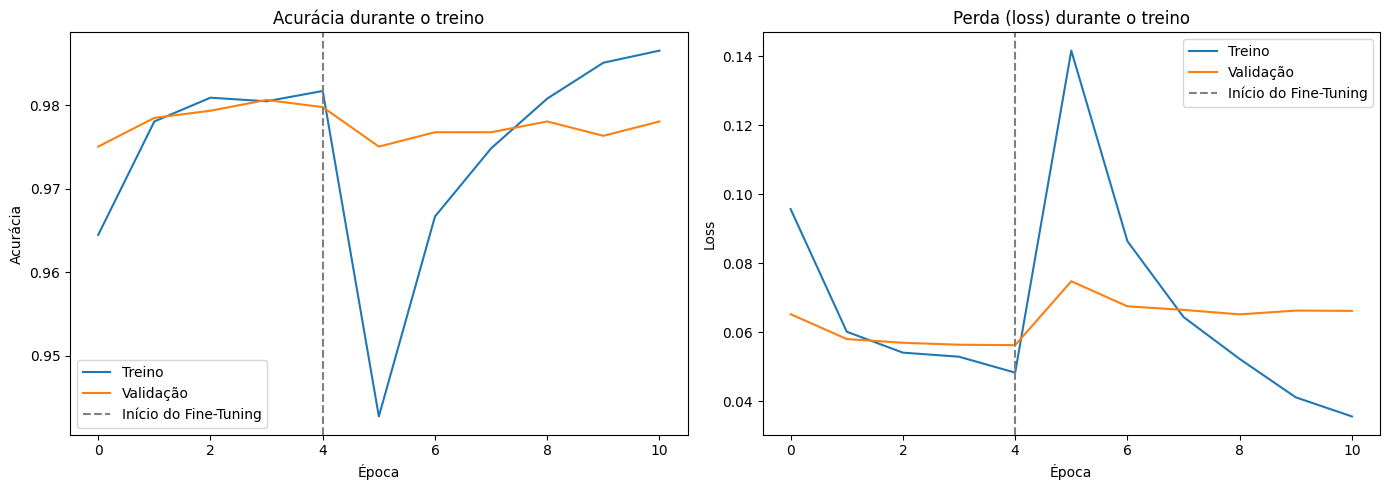

In [7]:
#Visualização dos resultados

# Junta os históricos anteriores
acc = history.history["accuracy"] + history_ft.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_ft.history["val_accuracy"]

loss = history.history["loss"] + history_ft.history["loss"]
val_loss = history.history["val_loss"] + history_ft.history["val_loss"]

epochs_range = range(len(acc))

# Plotando
plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Treino")
plt.plot(epochs_range, val_acc, label="Validação")
plt.axvline(x=history.epoch[-1], color="gray", linestyle="--", label="Início do Fine-Tuning")
plt.title("Acurácia durante o treino")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Treino")
plt.plot(epochs_range, val_loss, label="Validação")
plt.axvline(x=history.epoch[-1], color="gray", linestyle="--", label="Início do Fine-Tuning")
plt.title("Perda (loss) durante o treino")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Teste final com imagem nova (cachorro)
img = image.load_img("/content/dog.jpg", target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Faz a previsão
prediction = model.predict(img_array)

# probabilidade da classe "Dog"
score = prediction[0][0]

# Calcula probabilidades das duas classes
prob_cat = 1 - score
prob_dog = score

# Define a classe final prevista
class_names = ["Cat", "Dog"]
predicted_class = class_names[int(score > 0.5)]

# Exibe resultados
print(f"Predição: {predicted_class}")
print(f"Probabilidade de Cat: {prob_cat:.4f}")
print(f"Probabilidade de Dog: {prob_dog:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predição: Dog
Probabilidade de Cat: 0.0084
Probabilidade de Dog: 0.9916


In [9]:
# Teste final com imagem nova (gato)
img = image.load_img("/content/cat.jpg", target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Faz a previsão
prediction = model.predict(img_array)

# probabilidade da classe "Dog"
score = prediction[0][0]

# Calcula probabilidades das duas classes
prob_cat = 1 - score
prob_dog = score

# Define a classe final prevista
class_names = ["Cat", "Dog"]
predicted_class = class_names[int(score > 0.5)]

# Exibe resultados
print(f"Predição: {predicted_class}")
print(f"Probabilidade de Cat: {prob_cat:.4f}")
print(f"Probabilidade de Dog: {prob_dog:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predição: Cat
Probabilidade de Cat: 0.9895
Probabilidade de Dog: 0.0105
